[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/brainsync/blob/master/deep_rigid.ipynb)

------------------------------
Loading and preprocessing train data...
------------------------------


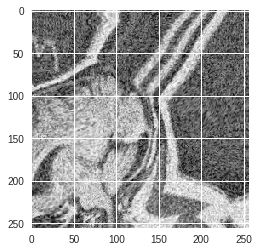

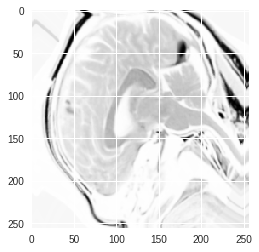

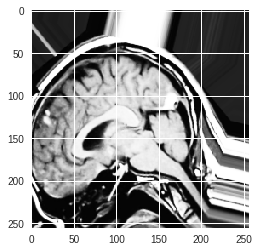

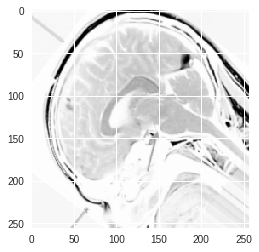

Creating and compiling model...
Fitting Model
Train on 819 samples, validate on 205 samples
Epoch 1/20
819/819 [==============================] - 13s 16ms/step - loss: 383.4724 - mean_squared_error: 383.4724 - val_loss: 183.4454 - val_mean_squared_error: 183.4454
Epoch 2/20
819/819 [==============================] - 12s 15ms/step - loss: 131.3320 - mean_squared_error: 131.3320 - val_loss: 100.5396 - val_mean_squared_error: 100.5396
Epoch 3/20
819/819 [==============================] - 12s 15ms/step - loss: 67.1994 - mean_squared_error: 67.1994 - val_loss: 54.5992 - val_mean_squared_error: 54.5992
Epoch 4/20
819/819 [==============================] - 12s 15ms/step - loss: 58.8466 - mean_squared_error: 58.8466 - val_loss: 94.3969 - val_mean_squared_error: 94.3969
Epoch 5/20
819/819 [==============================] - 12s 15ms/step - loss: 48.2829 - mean_squared_error: 48.2829 - val_loss: 42.0194 - val_mean_squared_error: 42.0194
Epoch 6/20
768/819 [===========================>..] - ETA: 0

819/819 [==============================] - 12s 15ms/step - loss: 35.2491 - mean_squared_error: 35.2491 - val_loss: 40.7328 - val_mean_squared_error: 40.7328
Epoch 7/20
819/819 [==============================] - 12s 15ms/step - loss: 32.6037 - mean_squared_error: 32.6037 - val_loss: 37.8181 - val_mean_squared_error: 37.8181
Epoch 8/20
819/819 [==============================] - 12s 15ms/step - loss: 28.7520 - mean_squared_error: 28.7520 - val_loss: 37.5367 - val_mean_squared_error: 37.5367
Epoch 9/20
819/819 [==============================] - 12s 15ms/step - loss: 27.0073 - mean_squared_error: 27.0073 - val_loss: 36.5823 - val_mean_squared_error: 36.5823
Epoch 10/20
819/819 [==============================] - 12s 15ms/step - loss: 24.8074 - mean_squared_error: 24.8074 - val_loss: 38.9041 - val_mean_squared_error: 38.9041
Epoch 11/20
819/819 [==============================] - 12s 15ms/step - loss: 21.6868 - mean_squared_error: 21.6868 - val_loss: 36.4097 - val_mean_squared_error: 36.4097
E

819/819 [==============================] - 12s 15ms/step - loss: 19.7163 - mean_squared_error: 19.7163 - val_loss: 37.3067 - val_mean_squared_error: 37.3067
Epoch 13/20
819/819 [==============================] - 12s 15ms/step - loss: 18.6516 - mean_squared_error: 18.6516 - val_loss: 39.2055 - val_mean_squared_error: 39.2055
Epoch 14/20
819/819 [==============================] - 12s 15ms/step - loss: 17.1621 - mean_squared_error: 17.1621 - val_loss: 44.5931 - val_mean_squared_error: 44.5931
Epoch 15/20
819/819 [==============================] - 12s 15ms/step - loss: 13.8482 - mean_squared_error: 13.8482 - val_loss: 42.4436 - val_mean_squared_error: 42.4436
Epoch 16/20
819/819 [==============================] - 12s 15ms/step - loss: 11.2001 - mean_squared_error: 11.2001 - val_loss: 47.0940 - val_mean_squared_error: 47.0940
Epoch 17/20
819/819 [==============================] - 12s 15ms/step - loss: 9.5613 - mean_squared_error: 9.5613 - val_loss: 46.6561 - val_mean_squared_error: 46.6561


819/819 [==============================] - 12s 15ms/step - loss: 7.1631 - mean_squared_error: 7.1631 - val_loss: 48.5201 - val_mean_squared_error: 48.5201
Epoch 19/20
819/819 [==============================] - 12s 15ms/step - loss: 6.0250 - mean_squared_error: 6.0250 - val_loss: 47.8077 - val_mean_squared_error: 47.8077
Epoch 20/20
819/819 [==============================] - 12s 15ms/step - loss: 6.5624 - mean_squared_error: 6.5624 - val_loss: 50.5380 - val_mean_squared_error: 50.5380
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


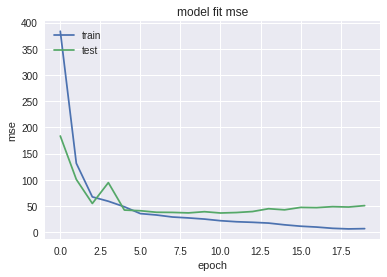

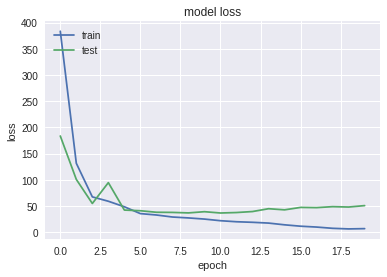

Test data...
4/4 [==============================] - 0s 69ms/step
[[ 6.3990444e+01 -3.5191364e+00  2.1872904e+00]
 [-1.2052578e+01 -2.4622053e-01  6.2722266e-02]
 [-3.2520008e+01 -5.8239162e-01  3.7629557e+00]
 [ 4.1171246e+01 -1.4499493e+00  4.5026317e+00]]
[[ 58.85778239   4.65275498  -4.7403063 ]
 [-13.02349081  -2.15157908  -8.08869388]
 [-36.01969722   2.4761903    7.86783001]
 [ 50.86884693   3.61223085   7.64033234]]


In [6]:
#AUM
#Shree Ganeshaya Namaha
from skimage import transform as tf
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage.io import imread
from keras.layers import Input,Conv2D,concatenate,MaxPooling2D,Flatten,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.viewer import ImageViewer
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

%matplotlib inline

from google.colab import files
uploaded = files.upload()


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

from keras import losses
img_rows = 256
img_cols = 256


#taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def get_rr_net():
    inputs = Input((img_rows, img_cols, 2))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    flat1 = Flatten()(conv5)
    d1= Dense(64,activation='relu')(flat1)
    out_theta = Dense(3)(d1)
#    conv_tx = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_ty = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_theta = Conv2D(1, (1, 1), activation='tanh')(conv5)

#    out_img = rotate(inputs,conv_theta)

    model = Model(inputs=[inputs], outputs=out_theta)

    model.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['mse'])

    return model


def gen_train_data(img, N=1024,  nodist=0):
    imgs_train = np.zeros((N, img.shape[0], img.shape[1], 2))
    noise = uniform(low=-1,high=1,size=imgs_train.shape)
    out_train = np.zeros((N, 3))
    rot = uniform(low=-60, high=60, size=(N,1))
    tx = uniform(low=-10, high=10, size=(N,1))
    ty = uniform(low=-10, high=10, size=(N,1))
    out_train[:,0]=rot.squeeze()
    out_train[:,1]=tx.squeeze()
    out_train[:,2]=ty.squeeze()

    in_rot = uniform(low=-60, high=60, size=(N,1))
 
    for j in range(N):
      
#        img2 = tf.warp(img,aff)
        img2 = rotate(img, in_rot[j],mode='edge')
        img2 -= np.mean(img2)
        img2 /= np.std(img2)
        if nodist==0:
            img2 = elastic_transform(img2, img2.shape[1] * 2, img2.shape[1] * 0.08,img2.shape[1] * 0.08)
            imgs_train[j, :, :, 0] = img2 + noise[j,:,:,0]
       
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*rot[j], translation=(tx[j],ty[j]))

        #img3 = 10-1*np.tanh(img2) + 0*  noise[j,:,:,1]#
        img3 = 10-1*np.tanh(tf.warp(img2, aff, mode='edge')) +  (1.0-nodist)*noise[j,:,:,1]#
        
        if nodist == 0:
            img3 = elastic_transform(img3, img3.shape[1] * 2, img3.shape[1] * 0.08,img3.shape[1] * 0.08)

        img3 -= np.mean(img3)
        img3 /= np.std(img3)
        imgs_train[j, :, :, 1] = img3
        
        if j==1:
            plt.imshow(img3)
            plt.show()
            
            plt.imshow(img2)
            plt.show()
 
            
    return imgs_train, out_train


def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='reflect')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std
    

    imgs_train, out_train = gen_train_data(img, 1024)
    imgs_test, out_test = gen_train_data(img, 4, nodist=1)

    print('Creating and compiling model...')
    rrmodel = get_rr_net()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('Fitting Model')
    history = rrmodel.fit(imgs_train, out_train, batch_size=32, epochs=20, verbose=1,
                shuffle=True, validation_split=0.2,
                callbacks=[model_checkpoint])
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model fit mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print('Test data...')
    rrmodel.load_weights('weights.h5')
    pred_theta = rrmodel.predict(imgs_test, verbose=1)
    print(pred_theta)
    print(out_test)



if __name__ == '__main__':
    train_and_predict()
